In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mini-clean-goodreads-train/mini_clean_train_goodreads.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


# Preprocessing

### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

### Importing and analyzing the datasets


In [4]:
goodreads_train = pd.read_csv("../input/goodreads-books-reviews-290312/goodreads_train.csv") 
goodreads_test = pd.read_csv("../input/goodreads-books-reviews-290312/goodreads_test.csv")

In [5]:
goodreads_test.shape

(478033, 10)

In [6]:
goodreads_train.shape 

(900000, 11)

In [7]:
goodreads_train.sample(5)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
78324,07478bd1f190f558caa85c08a98f029a,21473305,4d898165d6fa8888273169434302cb9f,4,You can find my Italian review of this book he...,Sun Feb 21 02:36:26 -0800 2016,Wed Apr 20 05:48:13 -0700 2016,Thu Feb 18 00:00:00 -0800 2016,Thu Feb 18 00:00:00 -0800 2016,0,0
414565,88e4407451355899b43ed6f6c3014623,28253785,95093ac527f26aaa667155385caaba07,5,I was so excited to get the conclusion to Step...,Sun Aug 14 07:36:44 -0700 2016,Sun Aug 14 07:39:29 -0700 2016,NaN,NaN,1,0
755709,fd549ae187739852557f305ef4565169,30264,6d69b6fea3c51edf1acf5091c4b62b21,0,[Copied across from Library Thing; 22 Septembe...,Sat Sep 21 19:39:13 -0700 2013,Fri Jul 01 03:24:35 -0700 2016,Wed Feb 21 00:00:00 -0800 2007,Sun Feb 04 00:00:00 -0800 2007,0,0
77891,e8e9347ecc8a0557a7e2fd7b72452558,28676,c3e4b9ead480b927fcd265e56de1d13b,3,I can't really give the book a rating just for...,Mon Sep 22 10:57:43 -0700 2008,Mon Sep 22 10:59:03 -0700 2008,Sat Jan 01 00:00:00 -0800 2000,NaN,0,0
199582,26bdaa12ddfa7284bb265427a9947ae5,18879201,35777278b4b0415f34617fd2482bf3aa,5,Another short read but this one was very good ...,Tue Aug 19 05:39:35 -0700 2014,Tue Aug 26 05:54:27 -0700 2014,Mon Aug 25 00:00:00 -0700 2014,Mon Aug 25 00:00:00 -0700 2014,0,0


In [8]:
goodreads_train.set_index("review_id", inplace=True)
goodreads_test.set_index("review_id", inplace=True)

Concating the train and test sets to EDA

In [9]:
books = pd.concat([goodreads_train.drop('rating', axis=1), goodreads_test], axis=0)
books_rates = goodreads_train['rating']

books.shape

(1378033, 9)

In [10]:
books.sample(5)

,user_id,book_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
review_id,,,,,,,,,
ceb0d290ef8010e5a13a287593a25d57,721c6eb1e85d5c73651135473ba8d399,11544421,May 2014 Review: Listened to this in Audio thi...,Fri Jan 18 11:28:14 -0800 2013,Fri Aug 07 09:25:43 -0700 2015,Wed Jul 01 00:00:00 -0700 2015,NaN,0,0
4dbce5102f7f8d0a76077c756483d5e8,8267e607ae97396b011fcf8d8dc2b645,24905116,A very nice conclusion to Ava and Malachi's st...,Thu Mar 19 16:57:40 -0700 2015,Tue Aug 08 17:37:22 -0700 2017,Wed May 27 00:00:00 -0700 2015,Thu May 21 00:00:00 -0700 2015,0,0
be71d67daf01e445405f6c4c68bfad8a,353474dfc88f6a3210451a818131b72c,16117804,I came to The Proposal straight from The Propo...,Sun Jun 16 18:09:27 -0700 2013,Mon Dec 30 21:59:44 -0800 2013,Sun Jun 16 00:00:00 -0700 2013,NaN,2,3
09aafd1d12dffe6ecb753f689ce5e313,45098b26765e1d5ce12515f2692c2616,13257637,Shana Abe is a very talented writer. This book...,Sun May 05 16:51:42 -0700 2013,Sun May 05 16:57:33 -0700 2013,Mon May 06 00:00:00 -0700 2013,NaN,0,0
7483621c427b8c6ccaa950213a2ad586,149e336726888ebcf2aa69214cf91538,11563110,"A good follow-up to ""Unearthly"", which I thoug...",Wed Dec 26 19:31:53 -0800 2012,Tue Jan 08 09:27:02 -0800 2013,Sun Dec 30 00:00:00 -0800 2012,Wed Dec 26 00:00:00 -0800 2012,0,0


In [11]:
# import tensorflow_data_validation as tfdv
# books_stats = tfdv.generate_statistics_from_dataframe(books)


In [12]:
# tfdv.visualize_statistics(books_stats)

In [13]:
# Droping some non-essential columns
books.drop(columns=['date_updated', 'read_at', 'started_at'], axis=1, inplace=True)

In [14]:
# Removing rows with negative n_votes or negative n_comments 
books = books[(books['n_votes'] >= 0) & (books['n_comments'] >= 0)]

In [15]:
# Checking duplications
sum(books.duplicated())

0

In [16]:
sum(books.duplicated(subset=['review_text']))

16130

In [17]:
books.drop_duplicates(subset=['review_text'], inplace=True)

In [18]:
# Finding unappropriate texts
unapp_texts = books['review_text'].apply(lambda txt: np.mean(list(map(len, txt.split())))) > 25
unapp_texts.shape

(1361800,)

In [19]:
books[unapp_texts].head()

,user_id,book_id,review_text,date_added,n_votes,n_comments
review_id,,,,,,
ba7e149d70cb858d87d4113dfe0e4091,8092e33e9c50d3e269a8164177d2abdc,6339664,IhavetoadmitihavefalleninlovewithPatcicannotwa...,Sun Sep 30 12:29:48 -0700 2012,1,1
90529a603506931b91502b3c65b0564c,308c545182f8b5d332ff71c667fd9b61,12127810,the feels for NICO DI ANGELO.....................,Thu May 16 23:11:00 -0700 2013,0,0
7105506d7aa373be892e6d7d29750741,302eb3debfc02e0bdd0fd617d34a2713,10644930,"""The past is obdurate."" \n rtcrtcrtcrtcrtcrtcr...",Fri Mar 18 07:59:13 -0700 2016,0,0
ba4e577524730630bef88cb4c76c6dd7,de107a99cb0ed2ec5d90d744cc48c310,23723788,2.5 it's-a-good-book-as-in-even-after-months-I...,Sun Aug 30 18:18:44 -0700 2015,0,0
d9d104943954cc9d975a07d1a724be90,de107a99cb0ed2ec5d90d744cc48c310,23496782,2.5 It-Was-a-Very-Okay-Book-With-the-Mystery-a...,Thu Apr 09 04:41:42 -0700 2015,3,0


In [20]:
books.drop(books[unapp_texts].index, axis=0, inplace=True)

In [21]:
spoil_statement = 'spoiler alert'
books['spoil'] = [True if spoil_statement in txt else False for txt in books['review_text']]

In [22]:
books[books['spoil'] == True]

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil
review_id,,,,,,,
e23965adda7ce7e7e415a1339e169065,8842281e1d1347389f2ab93d60773d4d,62291,** spoiler alert ** \n Loved it. The epic saga...,Tue Jul 12 12:57:07 -0700 2011,5,1,True
0258b3c9a85cecb95f240e43a7642f60,8842281e1d1347389f2ab93d60773d4d,7112495,** spoiler alert ** \n An interesting book in ...,Thu Jun 10 14:41:13 -0700 2010,7,3,True
d44b6d28f456dbcc5b1537b4c5572400,8842281e1d1347389f2ab93d60773d4d,6411961,"** spoiler alert ** \n Critics aside, Dan Brow...",Wed Sep 16 11:09:03 -0700 2009,3,3,True
d49eb786ef1d8557b9e6e86bcafd4570,8842281e1d1347389f2ab93d60773d4d,77432,"** spoiler alert ** \n I equally loved book 2,...",Tue May 05 18:08:22 -0700 2009,1,0,True
b8e08587ce1592d69548d0f644cb9893,8842281e1d1347389f2ab93d60773d4d,14497,** spoiler alert ** \n Just finished this and ...,Thu Mar 27 17:53:06 -0700 2008,6,1,True
...,...,...,...,...,...,...,...
a989c818917a7463089454b356fb6671,5ff0927d425ab1a70d2b2d41fe6b96b5,13239950,** spoiler alert ** \n Hills like White Elepha...,Wed Oct 31 18:22:50 -0700 2012,25,7,True
3736d5ee5904b4b5651912dd28b7ce01,a16fd6b48c6e877042acbe2bda8a0007,115076,** spoiler alert ** \n I was completely engros...,Mon Jun 04 07:18:34 -0700 2012,0,0,True
a7777a1c18ab582586a61ad453d91949,692ce8eb4d5490980f6e74f6cb8671e2,12974372,** spoiler alert ** \n Hmm...what to say about...,Wed Nov 04 12:33:22 -0800 2015,1,0,True


### Preprocessing the review texts

In [23]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [24]:
# Removing punctuation and converting the characters to lowercase
# NOTE! : It's need considerable time about 18 min --> It will improve


## Way 1
import string
exclist = string.punctuation + string.digits
lamitizer = WordNetLemmatizer()
stopwords_list = stopwords.words('english')

def preprocessing_text(txt):
    words = txt.translate(str.maketrans(exclist, ' '*len(exclist))).lower().split()

    return (' '.join([lamitizer.lemmatize(word) for word in words if word not in stopwords_list])).strip()


books['review_text_tokens'] = books['review_text'].progress_apply(preprocessing_text)

books['review_text_tokens'].sample(5)


100%|██████████| 1361774/1361774 [19:11<00:00, 1182.41it/s]


review_id
f4c5b8b725418f0578da7e2b44e7658f    also pointing defect teaching use benefit coun...
d0d063bfa14efdf7312b2ed467d34d4f    first trek world sookie stackhouse course star...
0b5de0f2ae1a777489536602be33c047    end one favorite historical fiction novel grea...
5f5eb2d3f9b9ccabb705239ed7c30573    start saying hate princess run away want marry...
a788729a7290a1c0d0df50d1394d4ef3    main character sometimes annoyed like really n...
Name: review_text_tokens, dtype: object

In [25]:
books.sample(4)

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil,review_text_tokens
review_id,,,,,,,,
ea6f6de43d677becc74223b84e679ac2,fc42cbb17f863f27ab7b8b231ef6e49a,14836,"Stephen King says: ""1,001 children are born in...",Mon Mar 07 15:30:39 -0800 2011,1,0,False,stephen king say child born india midnight aug...
ef6ed8439ff80da13cf2eb7ff0e199a2,e137d592309be33416a6780014724927,10161216,A well-done mystery novel.,Mon Aug 06 21:41:01 -0700 2012,1,0,False,well done mystery novel
6bbd7cdc1d8bc2f6a26aeef5d05cd6db,80611c0216a6bc04cbaf489abcf002a7,11040554,I cannot tell you how happy and how I angry I ...,Tue Jun 19 14:43:49 -0700 2012,1,1,False,cannot tell happy angry book happy finally don...
5c10cd8ae4fdb1232963dca6937f4496,795ed3fcf5aa6c1a00b75b19abf2e892,6740548,"Reread this and wow, what a beautiful story. A...",Fri Feb 01 14:01:13 -0800 2013,1,1,False,reread wow beautiful story absolutely heartbre...


In [26]:
datetime_format = '%a %b %d %H:%M:%S %z %Y'
books['date_added'] = pd.to_datetime(books['date_added'], format=datetime_format, utc=True)

books.sample(5)

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil,review_text_tokens
review_id,,,,,,,,
6234cb70c3a702c112b6caf8450f4580,9d3db1ad4cde377b32beb8a666ecc111,13615258,Reviewed for THC Reviews \n While I can't call...,2017-09-13 06:54:13+00:00,2,0,False,reviewed thc review call big fan divergent ser...
0bee103d1fa7dabdb4a4fbdaa10251d3,4a43bd159aa056c3849a4f0dec4706f0,28374007,5 stars \n review to come,2016-09-06 22:09:49+00:00,0,0,False,star review come
385e133de7123261ea44ecb576d1f64f,f7cb1d70717e5177da086e91693b3bd8,22521552,I won this book as a FirstRead. \n Rodin's Lov...,2014-12-17 10:55:59+00:00,0,0,False,book firstread rodin lover tell story camille ...
7664cf85e889370f32cb54b824ea38d5,9d256b5ee65d0d2314999db699e2c329,4497978,"I'm not gonna give this book a rating, because...",2010-06-09 17:30:14+00:00,2,0,False,gonna give book rating knew would bad going pl...
d526e45c8419fec6cda1d8f4fd7961da,36f6764cf69581a7429d9f072c726145,13128982,Bought this on sale at Diesel (80%-off) or I m...,2013-03-13 03:07:21+00:00,0,0,False,bought sale diesel might never given shot read...


# Exploratory Data Analysis


<AxesSubplot:title={'center':'10 Date with most reviews'}, xlabel='Dates', ylabel='Count'>

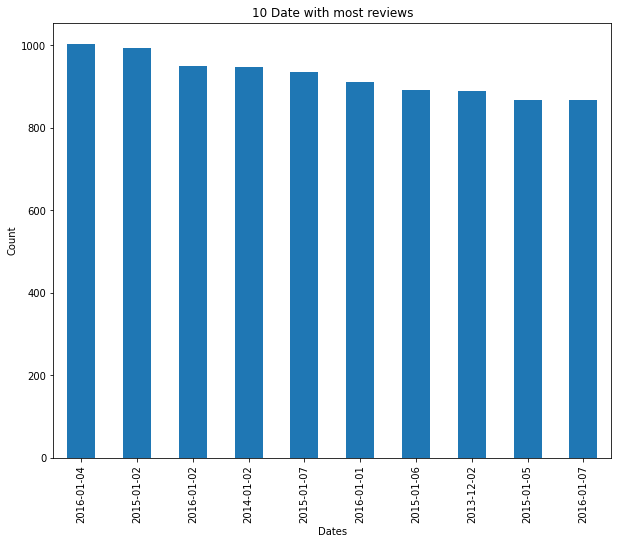

In [27]:
books_dates_added = books['date_added'].dt.date
books_dates_added.value_counts()[:10].plot(kind='bar', 
                                            figsize=(10, 8),
                                            title='10 Date with most reviews',
                                            xlabel='Dates',
                                            ylabel='Count')

<AxesSubplot:title={'center':'Number of rating action in days of all weeks'}, xlabel='Day of week', ylabel='Count'>

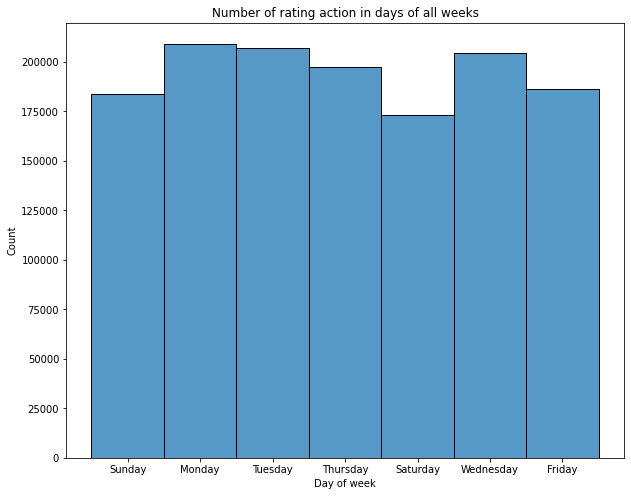

In [28]:
plt.figure(figsize=(10, 8))
plt.title("Number of rating action in days of all weeks")
plt.xlabel("Day of week")
plt.ylabel("Count")
sns.histplot(books['date_added'].dt.day_name())

<AxesSubplot:title={'center':'Number of rating action in months of all years'}, xlabel='Month of week', ylabel='Count'>

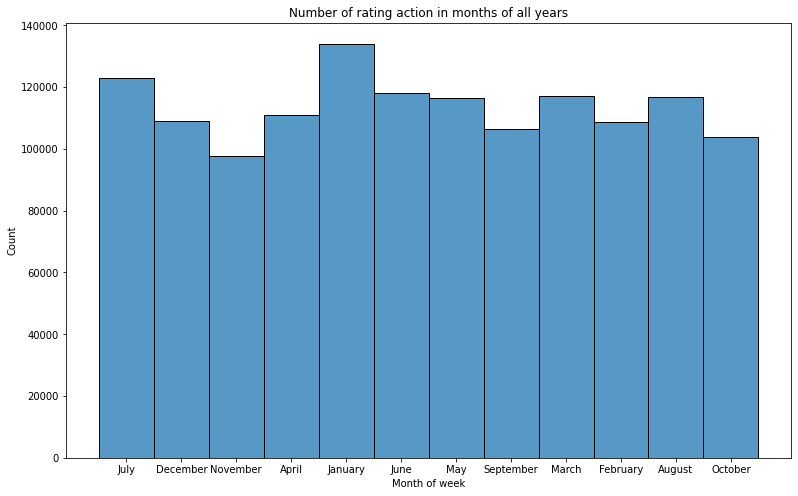

In [29]:
plt.figure(figsize=(13, 8))
plt.title("Number of rating action in months of all years")
plt.xlabel("Month of week")
plt.ylabel("Count")
sns.histplot(books['date_added'].dt.month_name())

<AxesSubplot:title={'center':'10 books with the most reviews'}, xlabel='Book id', ylabel='Number of reviews'>

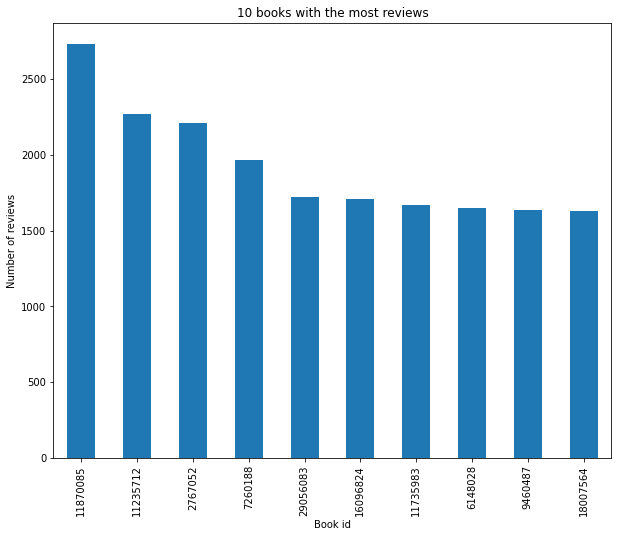

In [30]:
books.groupby('book_id').count() \
                .sort_values(by='user_id', ascending=False)['user_id'][:10] \
                .plot(kind='bar', 
                        figsize=(10, 8),
                        title='10 books with the most reviews',
                        xlabel='Book id',
                        ylabel='Number of reviews')

<AxesSubplot:title={'center':'10 users with the most reviews'}, xlabel='User id', ylabel='Number of reviews'>

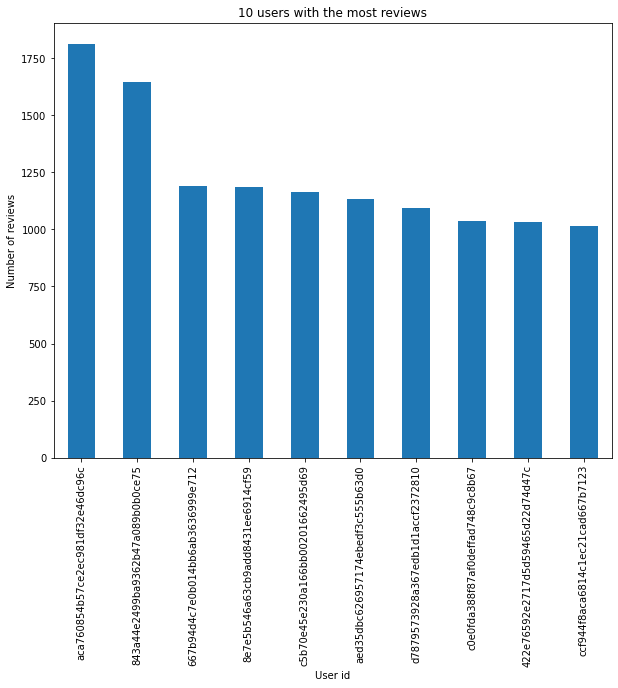

In [31]:
books.groupby('user_id').count() \
        .sort_values(by='book_id', ascending=False)['book_id'][:10] \
        .plot(kind='bar',
                figsize=(10, 8),
                title='10 users with the most reviews',
                xlabel='User id',
                ylabel='Number of reviews')

<AxesSubplot:title={'center':'Number of Spoilers Vs. NO Spoilers'}, xlabel='Tags', ylabel='Count'>

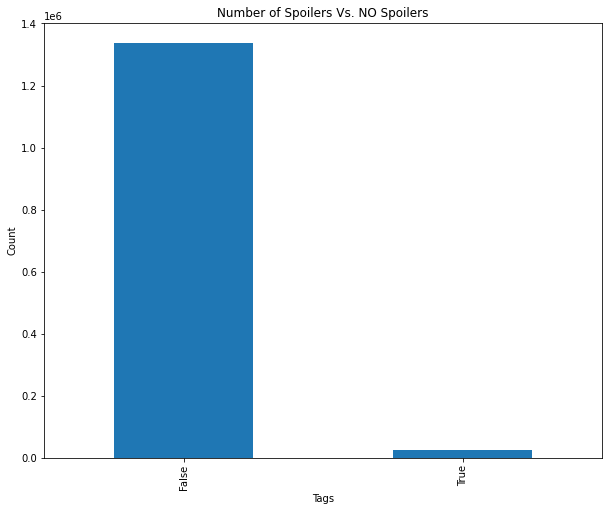

In [32]:
books['spoil'].value_counts().plot(kind='bar', 
                                    figsize=(10, 8),
                                    title='Number of Spoilers Vs. NO Spoilers',
                                    xlabel='Tags',
                                    ylabel='Count')

In [33]:
books_rates.sample(5)

review_id
0b92155e9fe5f54a411fd139740b9b11    4
73b6db95acc614d7f778e068490360e9    3
89657e29ba813adad80729e43fd35021    0
29856ba1326a188c2f87e14a74dc9949    4
794be7e62b34461efd3ca202528faffc    4
Name: rating, dtype: int64

In [34]:
clean_books_rate = books.merge(books_rates, how='inner', on='review_id')
clean_books_rate.sample(3)

,user_id,book_id,review_text,date_added,n_votes,n_comments,spoil,review_text_tokens,rating
review_id,,,,,,,,,
85fd1eefef19d403d61e44ad91369360,2ce2f3fece4b516db9cdf94bf6b06f42,9266793,I sat down and read this entire book for 8 hou...,2013-03-11 20:34:18+00:00,0,0,False,sat read entire book hour done amazing,5
4828f48b80f63f0750004fb827127717,9712ccbd2a46262ebce99fe566c093f6,6587387,** spoiler alert ** \n Let me begin by saying....,2011-08-20 19:06:04+00:00,11,0,True,spoiler alert let begin saying love series mig...,4
9b7a7042a352d4faf03134b794a50a07,9d99d1c0336449e5513e2b5a4a8703fc,52357,"If you are going to read this, read the Seamus...",2008-04-29 04:24:08+00:00,0,0,False,going read read seamus heaney trans even bette...,4


<AxesSubplot:title={'center':'The Number of each rate'}, xlabel='Rate', ylabel='Count'>

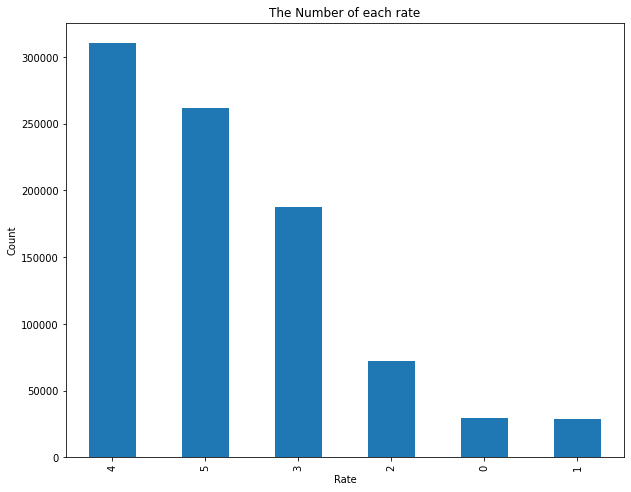

In [35]:
clean_books_rate['rating'].value_counts().plot(kind='bar', 
                                                figsize=(10, 8),
                                                title='The Number of each rate',
                                                xlabel='Rate',
                                                ylabel='Count')

<AxesSubplot:title={'center':'The Mean of rateing per book'}, ylabel='Frequency'>

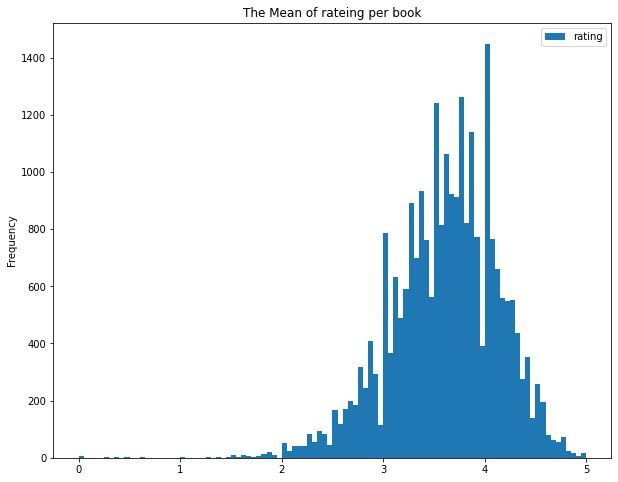

In [36]:
clean_books_rate.groupby(by='book_id').mean()['rating'] \
                    .plot(kind='hist', 
                            figsize=(10, 8),
                            title='The Mean of rateing per book',
                            xlabel='Value',
                            bins=100, 
                            legend=True)

<AxesSubplot:title={'center':'The STD of rateing per book'}, ylabel='Frequency'>

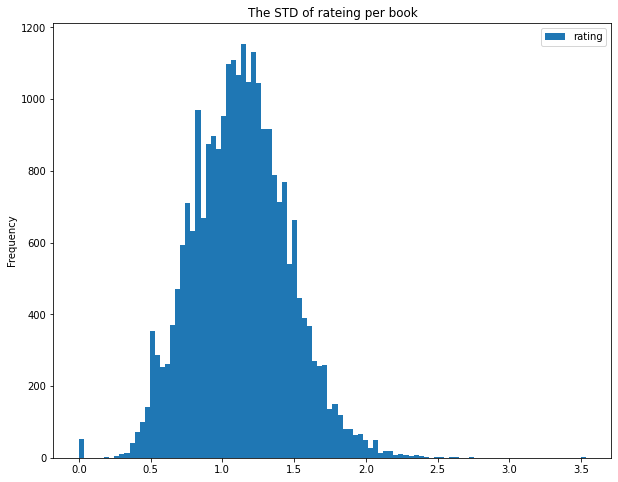

In [37]:
clean_books_rate.groupby(by='book_id').std()['rating'] \
                    .plot(kind='hist', 
                            figsize=(10, 8),
                            title='The STD of rateing per book',
                            xlabel='Value',
                            bins=100, 
                            legend=True)

In [38]:
# from collections import Counter
# list1=['apple','egg','apple','banana','egg','apple']
# counts = Counter(list1)
# print(counts)
# # Counter({'apple': 3, 'egg': 2, 'banana': 1})

# # initialising dictionaries
# ini_dictionary1 = Counter({'nikhil': 1, 'akash' : 5,
#                      'manjeet' : 10, 'akshat' : 15})
# ini_dictionary2 = Counter({'akash' : 7, 'akshat' : 5,
#                                           'm' : 15})
  
# # printing initial dictionaries
# print ("initial 1st dictionary", str(ini_dictionary1))
# print ("initial 2nd dictionary", str(ini_dictionary2))
  
# # combining dictionaries
# # using Counter
# final_dictionary = ini_dictionary1 + ini_dictionary2
  
# # printing final result
# print ("final dictionary", str(final_dictionary))

# Prediction

## Machine Learning Methods

In [39]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
df = clean_books_rate[['review_text_tokens', 'rating']]

In [41]:
df.sample(4)

,review_text_tokens,rating
review_id,,
6570f4cce54ba8ae6eafa2bc15dfccb8,pooled ink review star quite sure expect hope ...,5
51005ad09d0b17d97bc866b5ec6380c7,pretty good read exactly expecting term settin...,4
eb8d3e64f3611bb8890899db415ac526,loved beginning end story seriously lacking mi...,3
fabc5b5a8304cd60e54b881d5fe00d0b,many thought one review follow murder mystery ...,4


In [42]:
# df.sample(10000).to_csv('mini_clean_train_goodreads.csv')

In [43]:
mini_df = df.sample(10000)

In [44]:
X = mini_df['review_text_tokens']
y = mini_df['rating']

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=404)


In [46]:
print("X Train set size: ", X_train.shape)
print("X Validation set size: ", X_val.shape)

X Train set size:  (8000,)
X Validation set size:  (2000,)


In [47]:
print("Y Train set size: ", y_train.shape)
print("Y Validation set size: ", y_val.shape)

Y Train set size:  (8000,)
Y Validation set size:  (2000,)


In [48]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

X_train_vectors = tfidf_vectorizer.fit_transform(X_train) 
X_val_vectors = tfidf_vectorizer.transform(X_val)

In [49]:
print(X_train_vectors.shape)
print(X_val_vectors.shape)

(8000, 31084)
(2000, 31084)


## * Logistic Regression

In [50]:
lr_model=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_model.fit(X_train_vectors, y_train)

LogisticRegression(C=10, solver='liblinear')

In [51]:
#Predict y value for test dataset
y_predict = lr_model.predict(X_val_vectors)
y_prob = lr_model.predict_proba(X_val_vectors)[:,1]

print("test accuracy", str(np.mean(y_val == y_predict)))
print("-"*60)
print(classification_report(y_val,y_predict))
print("-"*60)
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

test accuracy 0.434
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.44      0.11      0.17        65
           1       0.29      0.08      0.13        61
           2       0.30      0.14      0.19       178
           3       0.37      0.37      0.37       423
           4       0.44      0.50      0.46       722
           5       0.49      0.57      0.53       551

    accuracy                           0.43      2000
   macro avg       0.39      0.30      0.31      2000
weighted avg       0.42      0.43      0.42      2000

------------------------------------------------------------
Confusion Matrix: [[  7   4   6  13  17  18]
 [  2   5  18  19  12   5]
 [  2   6  25  59  66  20]
 [  1   0  26 157 178  61]
 [  3   1   8 130 358 222]
 [  1   1   1  43 189 316]]


## * Naive Bayes

In [52]:
multiNB_model = MultinomialNB()
multiNB_model.fit(X_train_vectors, y_train)

MultinomialNB()

In [53]:
#Predict y value for test dataset
y_predict = multiNB_model.predict(X_val_vectors)
y_prob = multiNB_model.predict_proba(X_val_vectors)[:,1]

print("test accuracy", str(np.mean(y_val == y_predict)))
print("-"*60)
print(classification_report(y_val,y_predict))
print("-"*60)
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

test accuracy 0.419
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00       178
           3       0.00      0.00      0.00       423
           4       0.38      0.93      0.54       722
           5       0.66      0.30      0.41       551

    accuracy                           0.42      2000
   macro avg       0.17      0.21      0.16      2000
weighted avg       0.32      0.42      0.31      2000

------------------------------------------------------------
Confusion Matrix: [[  0   0   0   0  54  11]
 [  0   0   0   0  59   2]
 [  0   0   0   2 170   6]
 [  0   0   0   0 406  17]
 [  0   0   0   0 672  50]
 [  0   0   0   0 385 166]]


## * SGD

In [54]:
sgd_model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=404)
sgd_model.fit(X_train_vectors, y_train)

SGDClassifier(alpha=0.001, random_state=404)

In [55]:
#Predict y value for test dataset
y_predict = sgd_model.predict(X_val_vectors)
# y_prob = sgd_model.predict_proba(X_val_vectors)[:,1] # Is not available for loss='hinge'

print("test accuracy", str(np.mean(y_val == y_predict)))
print("-"*60)
print(classification_report(y_val,y_predict))
print("-"*60)
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

test accuracy 0.434
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        65
           1       0.22      0.07      0.10        61
           2       0.31      0.11      0.16       178
           3       0.40      0.28      0.33       423
           4       0.45      0.41      0.43       722
           5       0.45      0.77      0.57       551

    accuracy                           0.43      2000
   macro avg       0.36      0.29      0.29      2000
weighted avg       0.41      0.43      0.40      2000

------------------------------------------------------------
Confusion Matrix: [[  6   3   3   6  17  30]
 [  6   4  11  14  11  15]
 [  2   5  19  57  57  38]
 [  4   2  21 119 180  97]
 [  0   3   7  80 296 336]
 [  0   1   0  24 102 424]]


## * XGBoost

In [56]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_vectors, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [57]:
#Predict y value for test dataset
y_predict = xgb_model.predict(X_val_vectors)
y_prob = xgb_model.predict_proba(X_val_vectors)[:,1] # Is not available for loss='hinge'

print("test accuracy", str(np.mean(y_val == y_predict)))
print("-"*60)
print(classification_report(y_val,y_predict))
print("-"*60)
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

test accuracy 0.435
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.12      0.20        65
           1       0.27      0.05      0.08        61
           2       0.36      0.11      0.17       178
           3       0.38      0.31      0.34       423
           4       0.43      0.56      0.49       722
           5       0.49      0.55      0.52       551

    accuracy                           0.43      2000
   macro avg       0.40      0.28      0.30      2000
weighted avg       0.42      0.43      0.41      2000

------------------------------------------------------------
Confusion Matrix: [[  8   3   1  11  23  19]
 [  2   3   6  17  28   5]
 [  3   3  20  59  70  23]
 [  2   0  22 131 203  65]
 [  2   2   4 102 406 206]
 [  0   0   2  29 218 302]]
